# **Desafio Codenation**

Descubra quem fez o ENEM 2016 apenas para treino

Neste desafio deverá descobrir quais estudantes estão fazendo a prova apenas para treino.
Tópicos

Neste desafio você aprenderá:

- Python
- Pandas
- Sklearn
- Regression
- Classification


## Detalhes

O contexto do desafio gira em torno dos resultados do ENEM 2016 (disponíveis no arquivo train.csv). Este arquivo, e apenas ele, deve ser utilizado para todos os desafios. Qualquer dúvida a respeito das colunas, consulte o [Dicionário dos Microdados do Enem 2016](https://s3-us-west-1.amazonaws.com/acceleration-assets-highway/data-science/dicionario-de-dados.zip).

Alguns estudantes decidem realizar prova do ENEM de forma precoce, como um teste (coluna **IN_TREINEIRO**). Neste desafio, você deve criar um modelo de classificação binária para inferir a mesma. Os resultados possíveis da sua resposta devem ser “0” ou “1”.

Salve sua resposta em um arquivo chamado answer.csv com duas colunas: **NU_INSCRICAO** e **IN_TREINEIRO**.

Neste notebook, iremos seguir os seguintes passos para fazer a classificação ideal do dataset fornecido: 

01) Importação das Bibliotecas e Datasets

02) Descrição dos Dados

03) Encontrando Correlação entre as Features

04) Preenchimento dos Valores Faltantes

05) Balanceamento da Classe Principal (SMOTE)

06) Seleção das Features

07) One Hot Encoder

08) Testando Modelos e Realizando Predição/Submissão

## 01) Importação das Bibliotecas e Datasets

In [236]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno
import scipy.stats as st
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings('ignore')

In [237]:
# Loading the dataframes
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

## 02) Descrição dos Dados

Vamos começar dando uma olhada geral nos dados que temos para ter uma idéia inicial sobre eles.

In [238]:
# Verifying the shape of the train and test data
train_data.shape, test_data.shape

((13730, 167), (4570, 43))

In [239]:
# Exclude the target column from the train data and matching the columns of the dataframes
target = 'IN_TREINEIRO'

y_train = train_data[target]

different = list(set(train_data.columns).difference(set(test_data.columns)))
different.remove(target)

train_data.drop(different, axis=1, inplace=True)

train_data.shape, test_data.shape

((13730, 44), (4570, 43))

In [240]:
train_data.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,NaN,0,NaN,0,0,0,0,0,0,0,0,1,1,1,1,436.3,495.4,581.2,1,1.0,120.0,120.0,120.0,80.0,80.0,520.0,D,D,C,A,A,C,H,A
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,1.0,0,2.0,0,0,0,0,0,0,0,0,1,1,1,1,474.5,544.1,599.0,1,1.0,140.0,120.0,120.0,120.0,80.0,580.0,A,A,B,A,A,A,NaN,A
2,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,CE,21,F,3,1,3,0,1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,D,C,A,A,A,NaN,A
3,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,RJ,25,F,0,1,1,9,1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,E,E,C,B,C,F,D
4,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,AM,28,M,2,1,1,4,1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,D,C,A,A,B,F,A


### Análise das Colunas

Das 167 colunas inicias no dataset de treino, restaram apenas 44, uma vez que para realizar o teste só foram disponibilizadas 44 colunas, então precisamos igualar as colunas para que o teste seja condizente com o treino.

Estas 44 colunas são representadas das seguintes formas:
1. `NU_INSCRICAO` (Número de Inscrição): Alfanumérico de 12 digitos, todos são distintos.
2. `CO_UF_RESIDENCIA` (Código da Unidade da Federação de residência): Numérico com 2 dígitos, possuíndo 27 valores distintos.
3. `SG_UF_RESIDENCIA` (Sigla da Unidade da Federação de residência): Alfanumérico com 2 dígitos, possuíndo 27 valores distintos.
4. `NU_IDADE` (Idade): Numérico de 3 dígitos.
5. `TP_SEXO` (Sexo): Alfanumérica com um dígito (M ou F)
6. `TP_COR_RACA` (Cor/raça): Numérico com 1 dígito (0: Não declarado, 1: Branca, 2: Preta, 3: Parda, 4: Amarela, 5: Indígena, 6: Não dispõe da informação)
7. `TP_NACIONALIDADE` (Nacionalidade): Numérico com 1 dígito (0: Não informado, 1: Brasileiro, 2: Brasileiro Naturalizado, 3: Estrangeiro, 4: Brasileiro Nascido no Exterior)
8. `TP_ST_CONCLUSAO` (Situação de Conclusão do Ensino Médio): Numérico com 1 dígito (1: Já conclui Ensino Médio, 2: Estou cursando e concluirei em 2016, 3: Estou cursando e concluirei após 2016, 4: Não conclui e não estou cursando o Ensino Médio)
9. `TP_ANO_CONCLUIU` (Ano de conclusão do Ensino Médio): Numérico com 2 dígitos (0: Não Informado, 1: 2015, 2: 2014, 3: 2013, 4: 2012, 5: 2011, 6: 2010, 7: 2009, 8: 2008, 9: 2007, 10: Anterior a 2007)
10. `TP_ESCOLA` (Tipo de escola do Ensino Médio): Numérico com 1 dígito (1: Não Respondeu, 2: Pública, 3: Privada, 4: Exterior)
11. `TP_ENSINO` (Tipo de instituição de concluiu ou concluirá o Ensino Médio): Numérico com 1 dígito (1: Ensino Regular, 2: Educação Especial, 3: Educação de Jovens e Adultos) (Missing 68%)
12. `IN_TREINEIRO` **(Candidato treineiro): Numérico de 1 dígito (1: Sim, 0: Não)**
13. `TP_DEPENDENCIA_ADM_ESC` (Dependência Administrativa): Numérico com 1 dígito (1: Federal, 2: Estadual, 3: Municipal, 4: Privada) (Missing 68%)
14. `IN_BAIXA_VISAO` (Indicador de Baixa Visão): Numérico de 1 dígito (1: Sim, 0: Não)
15. `IN_CEGUEIRA` (Indicador de Cegueira): Numérico de 1 dígito (1: Sim, 0: Não) (100% dos valores são 0)
16. `IN_SURDEZ` (Indicador de Surdez): Numérico de 1 dígito (1: Sim, 0: Não)
17. `IN_DISLEXIA` (Indicador de Dislexia): Numérico de 1 dígito (1: Sim, 0: Não)
18. `IN_DISCALCULIA` (Indicador de Discalculia): Numérico de 1 dígito (1: Sim, 0: Não)
19. `IN_SABATISTA` (Indicador de Sabatista): Numérico de 1 dígito (1: Sim, 0: Não)
20. `IN_GESTANTE` (Indicador de Gestante): Numérico de 1 dígito (1: Sim, 0: Não)
21. `IN_IDOSO` (Indicador de Idoso): Numérico de 1 dígito (1: Sim, 0: Não)
22. `TP_PRSENCA_CN` (Presença na Prova de Ciências da Natureza) Numérico de 1 dígito (0: Faltou a Prova, 1: Presente na Prova, 2: Eliminado da Prova)
23. `TP_PRESENCA_CH` (Presença na Prova de Ciências Humanas) Numérico de 1 dígito (0: Faltou a Prova, 1: Presente na Prova, 2: Eliminado da Prova)
24. `TP_PRESENCA_LC` (Presença na Prova de Linguagens e Códigos) Numérico de 1 dígito (0: Faltou a Prova, 1: Presente na Prova, 2: Eliminado da Prova)
25. `TP_PRESENCA_MT` (Presença na Prova de Matemática) Numérico de 1 dígito (0: Faltou a Prova, 1: Presente na Prova, 2: Eliminado da Prova)
26. `NU_NOTA_CN` (Nota na Prova de Ciências da Natureza): Numérico de 9 dígitos
27. `NU_NOTA_CH` (Nota na Prova de Ciências Humanas): Numérico de 9 dígitos
28. `NU_NOTA_LC` (Nota na Prova de Linguagens e Códigos): Numérico de 9 dígitos
29. `TP_LINGUA`(Lingua Estrangeira): Numérico de 1 dígito (0: Inglês, 1: Espanhol)
30. `TP_STATUS_REDACAO` (Situação da Redação): Numérico de 1 dígito (1: Sem Problemas, 2: Anulada, 3: Copia Texto Motivador, 4: Em Branco, 5: Fere Direitos Humanos, 6: Fuga ao Tema, 7: Não Atendimento ao Tipo, 8: Texto Insuficiente, 9: Parte Desconectada)
31. `NU_NOTA_COMP1` (Nota da Competência 1): Numérico
32. `NU_NOTA_COMP2` (Nota da Competência 2): Numérico
33. `NU_NOTA_COMP3` (Nota da Competência 3): Numérico
34. `NU_NOTA_COMP4` (Nota da Competência 4): Numérico
35. `NU_NOTA_COMP5` (Nota da Competência 5): Numérico
36. `NU_NOTA_REDACAO` (Nota da Prova de Redação): Numérico
37. `Q001` (Até que série seu pai, ou o homem responsável por você, estudou?): Alfanumérico com 1 dígito (A: Nunca Estudou, B: Não completou a 4ª série/5º ano do Ensino Fundamental, C: Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental, D: Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio, E: Completou o Ensino Médio, mas não completou a Faculdade, F: Completou a Faculdade, mas não completou a Pós-graduação, Completou a Pós-graduação, H: Não sei)
38. `Q002` (Até que série sua mãe, ou a mulher responsável por você, estudou?): Alfanumérico com 1 dígito (A: Nunca Estudou, B: Não completou a 4ª série/5º ano do Ensino Fundamental, C: Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental, D: Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio, E: Completou o Ensino Médio, mas não completou a Faculdade, F: Completou a Faculdade, mas não completou a Pós-graduação, Completou a Pós-graduação, H: Não sei)
39. `Q006` (Qual é a renda mensal de sua família? (Some a sua renda com a dos seus familiares.)): Alfanumérico com 1 dígito (A: Nenhuma renda, B: Até 880,00, C: De 880,01 até 1.320,00, D: De 1.320,01 até 1.760,00, E: De 1.760,01 até 2.200,00, F: De 2.200,01 até 2.640,00, G: De 2.640,01 até 3.520,00, H: De 3.520,01 até 4.400,00, I: De 4.400,01 até 5.280,00, J: De 5.280,01 até 6.160,00, K: De 6.160,01 até 7.040,00, L: De 7.040,01 até 7.920,00, M: De 7.920,01 até 8.800,00, N: De 8.800,01 até 10.560,00, O: De 10.560,01 até 13.200,00, P: De 13.200,01 até 17.600,00, Q: Mais de 17.600,00)
40. `Q024` (Na sua residência tem computador?): Alfanumérico com 1 dígito (A: Não, B: Sim, um, C: Sim, dois, D: Sim, três, E: Sim, quatro ou mais)
41. `Q025` (Na sua residência tem acesso à Internet?): Alfanumérico com 1 dígito (A: Não, B: Sim)
42. `Q026` (Você exerce ou já exerceu atividade remunerada?): Alfanumérico com 1 dígito (A: Não, nunca trabalhei, B: Sim, já trabalhei, mas não estou trabalhando, C: Sim, estou trabalhando)
43. `Q027` (Com que idade você começou a exercer uma atividade remunerada?): Alfanumérico com 1 dígito (A: Menos de 14 anos, B: 14 anos, C: 15 anos, D: 16 anos, E: 17 anos, F: 18 anos, G: 19 anos, H: 20 anos, I: 21 anos, J: 22 anos, K: 23 anos, L: 24 anos, M: 25 anos ou mais) (Missing 53%)
44. `Q047` (Em que tipo de escola você frequentou o Ensino Médio?): Alfanumérico com 1 dígito (A: Somente em escola pública, B: Parte em escola pública e parte em escola privada sem bolsa de estudo integral, C: Parte em escola pública e parte em escola privada com bolsa de estudo integral, D: Somente em escola privada sem bolsa de estudo integral, E: Somente em escola privada com bolsa de estudo integral)

**Obesrvação**: Claramente as colunas `NU_INSCRICAO`, `SG_UF_RESIDENCIA` não terão relação com a nossa predição.

In [241]:
# Looking the type of the columns in the dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 44 columns):
NU_INSCRICAO              13730 non-null object
CO_UF_RESIDENCIA          13730 non-null int64
SG_UF_RESIDENCIA          13730 non-null object
NU_IDADE                  13730 non-null int64
TP_SEXO                   13730 non-null object
TP_COR_RACA               13730 non-null int64
TP_NACIONALIDADE          13730 non-null int64
TP_ST_CONCLUSAO           13730 non-null int64
TP_ANO_CONCLUIU           13730 non-null int64
TP_ESCOLA                 13730 non-null int64
TP_ENSINO                 4282 non-null float64
IN_TREINEIRO              13730 non-null int64
TP_DEPENDENCIA_ADM_ESC    4282 non-null float64
IN_BAIXA_VISAO            13730 non-null int64
IN_CEGUEIRA               13730 non-null int64
IN_SURDEZ                 13730 non-null int64
IN_DISLEXIA               13730 non-null int64
IN_DISCALCULIA            13730 non-null int64
IN_SABATISTA              13730 non-null

In [242]:
# The description of the train dataset
train_data.describe()

,CO_UF_RESIDENCIA,NU_IDADE,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO
count,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,4282.000000,13730.000000,4282.000000,13730.000000,13730.0,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,10341.000000,10341.000000,10133.000000,13730.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000
mean,30.736708,21.593809,2.185652,1.048871,1.782666,2.146176,1.353532,1.178888,0.129862,2.259692,0.001238,0.0,0.000364,0.000073,0.000073,0.009687,0.000947,0.000146,0.754479,0.754479,0.738747,0.738747,473.495155,529.661087,516.472841,0.593664,1.101747,119.811704,111.915918,106.824238,113.123951,77.372446,529.048258
std,9.862405,7.043654,1.007285,0.258895,0.880734,3.217328,0.558472,0.565490,0.336163,0.698586,0.035167,0.0,0.019080,0.008534,0.008534,0.097947,0.030757,0.012069,0.431932,0.431932,0.440162,0.440162,71.093674,73.726344,68.688190,0.491167,0.700100,29.846017,33.737588,34.341349,33.480033,43.067140,154.294758
min,11.000000,13.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,17.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,419.900000,480.400000,468.100000,0.000000,1.000000,120.000000,100.000000,80.000000,100.000000,40.000000,440.000000
50%,31.000000,19.000000,3.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,459.800000,532.000000,520.900000,1.000000,1.000000,120.000000,120.000000,120.000000,120.000000,80.000000,540.000000
75%,35.000000,23.000000,3.000000,1.000000,2.000000,3.000000,2.000000,1.000000,0.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,514.500000,581.200000,564.900000,1.000000,1.000000,140.000000,120.000000,120.000000,120.000000,100.000000,600.000000
max,53.000000,67.000000,5.000000,4.000000,4.000000,10.000000,4.000000,3.000000,1.000000,4.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,806.400000,807.000000,763.600000,1.000000,9.000000,200.000000,200.000000,200.000000,200.000000,200.000000,1000.000000


## 03) Encontrando Correlação entre as Features


In [243]:
# Showing the numerical varibales with the highest correlation with 'NU_NOTA_MT', sorted from highest to lowest
correlation = train_data.select_dtypes(include=[np.number]).corr()
print(correlation['IN_TREINEIRO'].sort_values(ascending=False))

IN_TREINEIRO              1.000000
TP_ST_CONCLUSAO           0.533983
TP_PRESENCA_CN            0.094692
TP_PRESENCA_CH            0.094692
TP_PRESENCA_MT            0.092454
TP_PRESENCA_LC            0.092454
TP_COR_RACA               0.009676
TP_STATUS_REDACAO         0.006688
IN_SABATISTA              0.003824
IN_DISLEXIA              -0.003297
IN_DISCALCULIA           -0.003297
IN_IDOSO                 -0.004663
IN_SURDEZ                -0.007374
NU_NOTA_COMP1            -0.008709
IN_GESTANTE              -0.011893
IN_BAIXA_VISAO           -0.013602
TP_NACIONALIDADE         -0.015179
NU_NOTA_COMP2            -0.023308
NU_NOTA_COMP5            -0.025811
NU_NOTA_COMP4            -0.025958
NU_NOTA_REDACAO          -0.026328
NU_NOTA_LC               -0.028261
NU_NOTA_COMP3            -0.030147
CO_UF_RESIDENCIA         -0.034944
TP_LINGUA                -0.036395
NU_NOTA_CN               -0.037874
NU_NOTA_CH               -0.053460
TP_ESCOLA                -0.244562
TP_ANO_CONCLUIU     

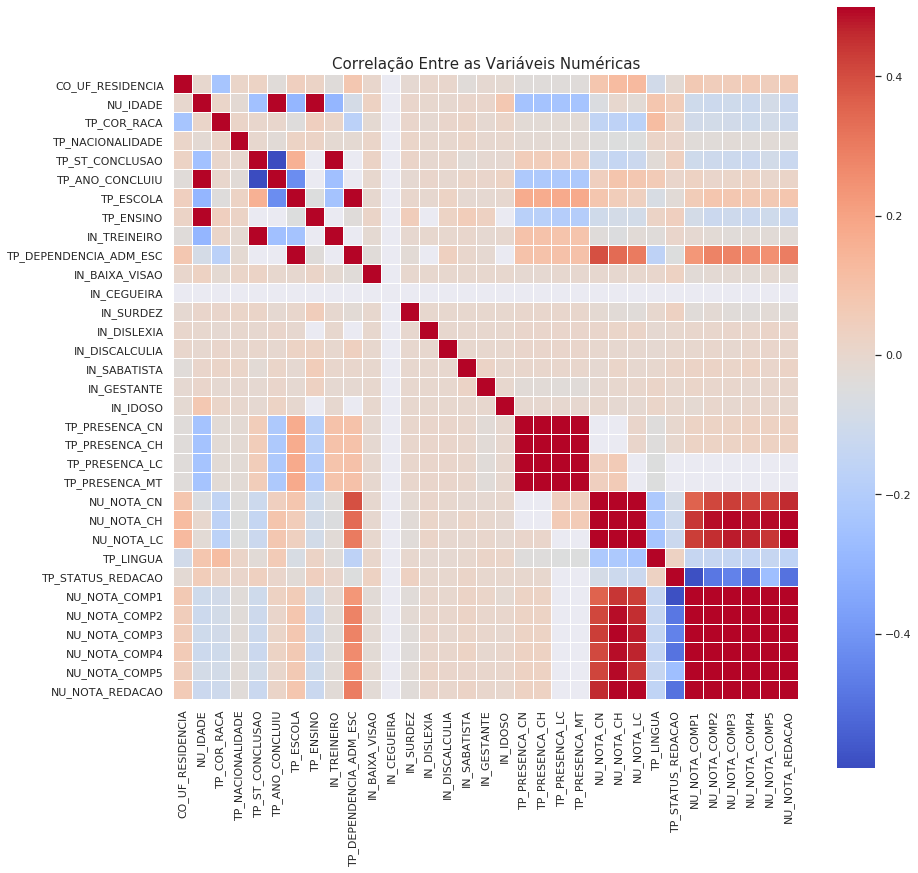

In [244]:
# Heatmap of correlation of numeric features
fig, ax = plt.subplots(figsize = (14,14))

plt.title('Correlação Entre as Variáveis Numéricas', size=15)

sns.heatmap(correlation, square=True, vmax=0.5, cmap='coolwarm', linewidths=0.01);

Podemos observar algumas correlações entre as variáveis numéricas:

* Para a variável alvo (`IN_TREINEIRO`), existem correlação com `TP_ST_CONCLUSAO`, `NU_IDADE`, `TP_ANO_CONCLUIU` e `TP_ESCOLA`

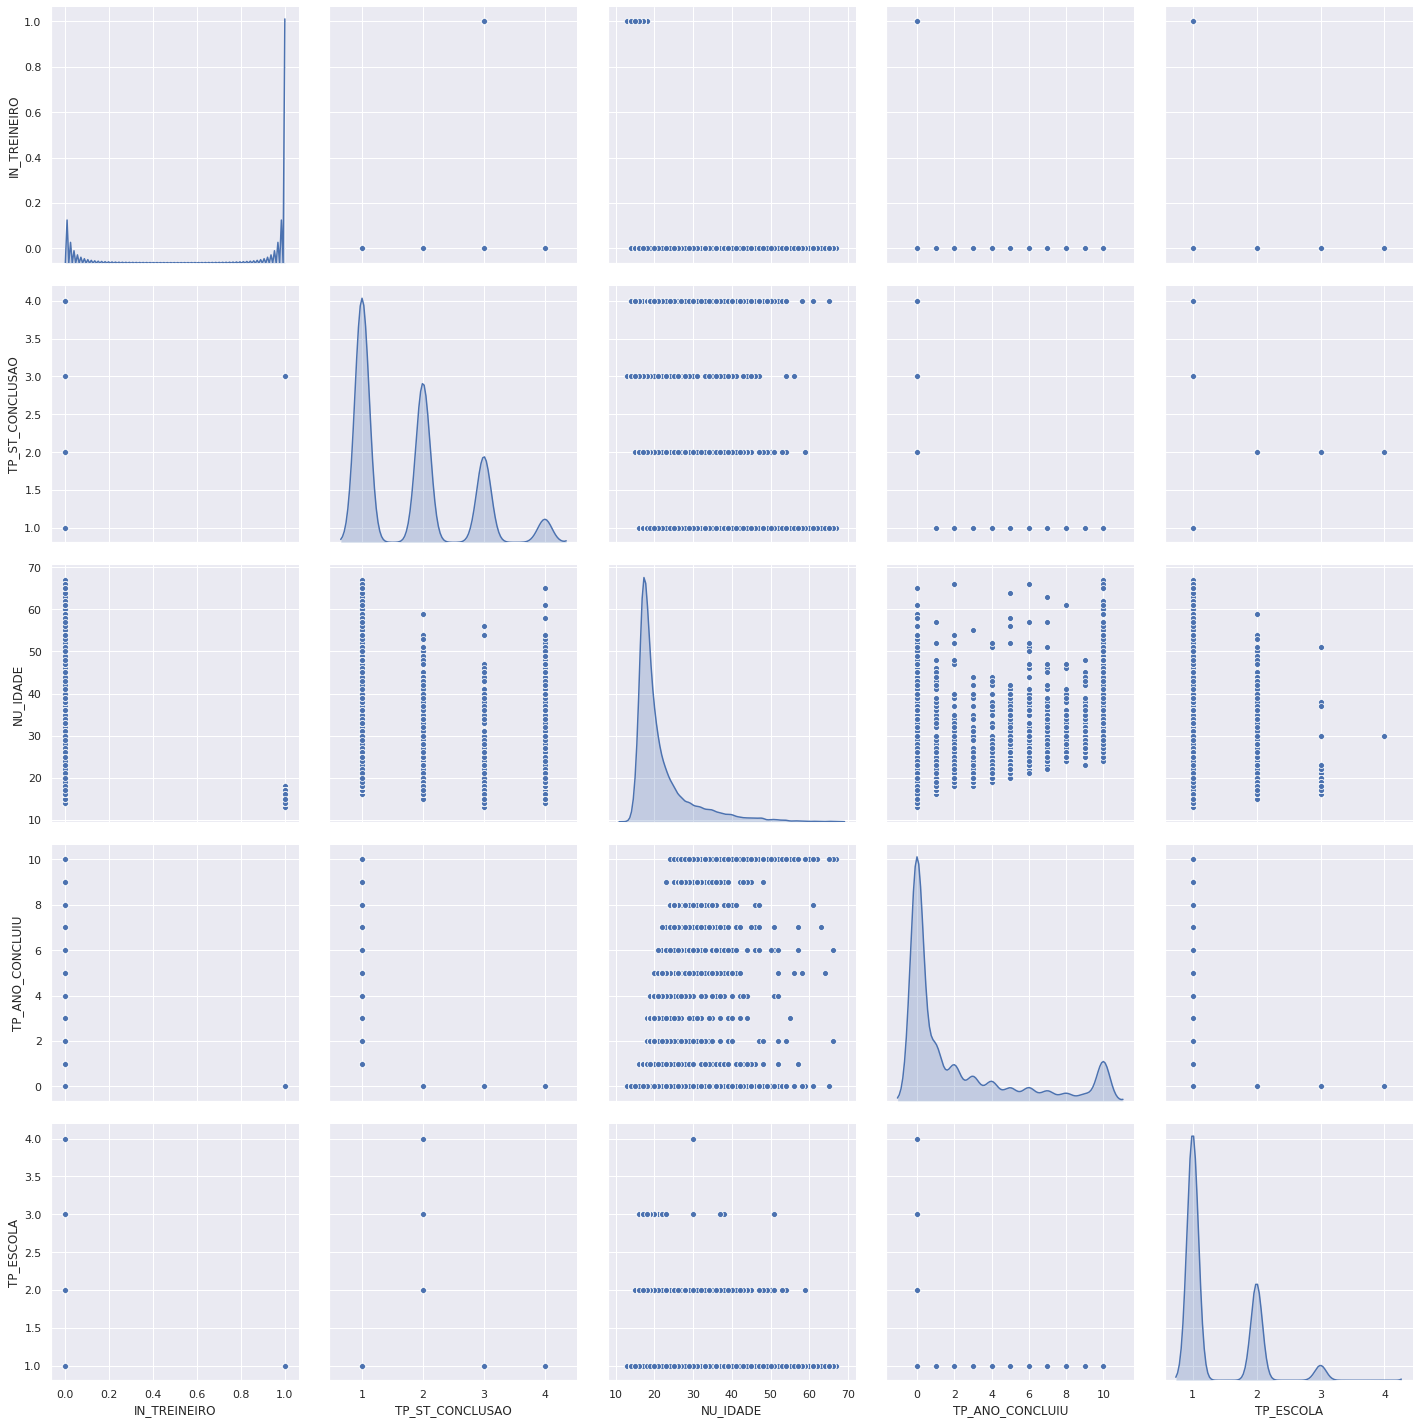

In [245]:
# Pair plot
cols = ['IN_TREINEIRO', 'TP_ST_CONCLUSAO', 'NU_IDADE', 'TP_ANO_CONCLUIU', 'TP_ESCOLA']

temp_train_data = train_data.fillna(0)

sns.set()
sns.pairplot(temp_train_data[cols], height=4, kind='scatter', diag_kind='kde')
plt.show()

## 04) Preenchimento dos Valores Faltantes

Vejamos o valores ausentes em nossos dados. Nós estaremos usando a biblioteca msno. Esta biblioteca fornece um pequeno conjunto de ferramentas de visualizações e utilitários de dados ausentes, flexíveis e fáceis de usar, que permitem obter um resumo visual rápido da integridade (ou falta dela) do conjunto de dados.

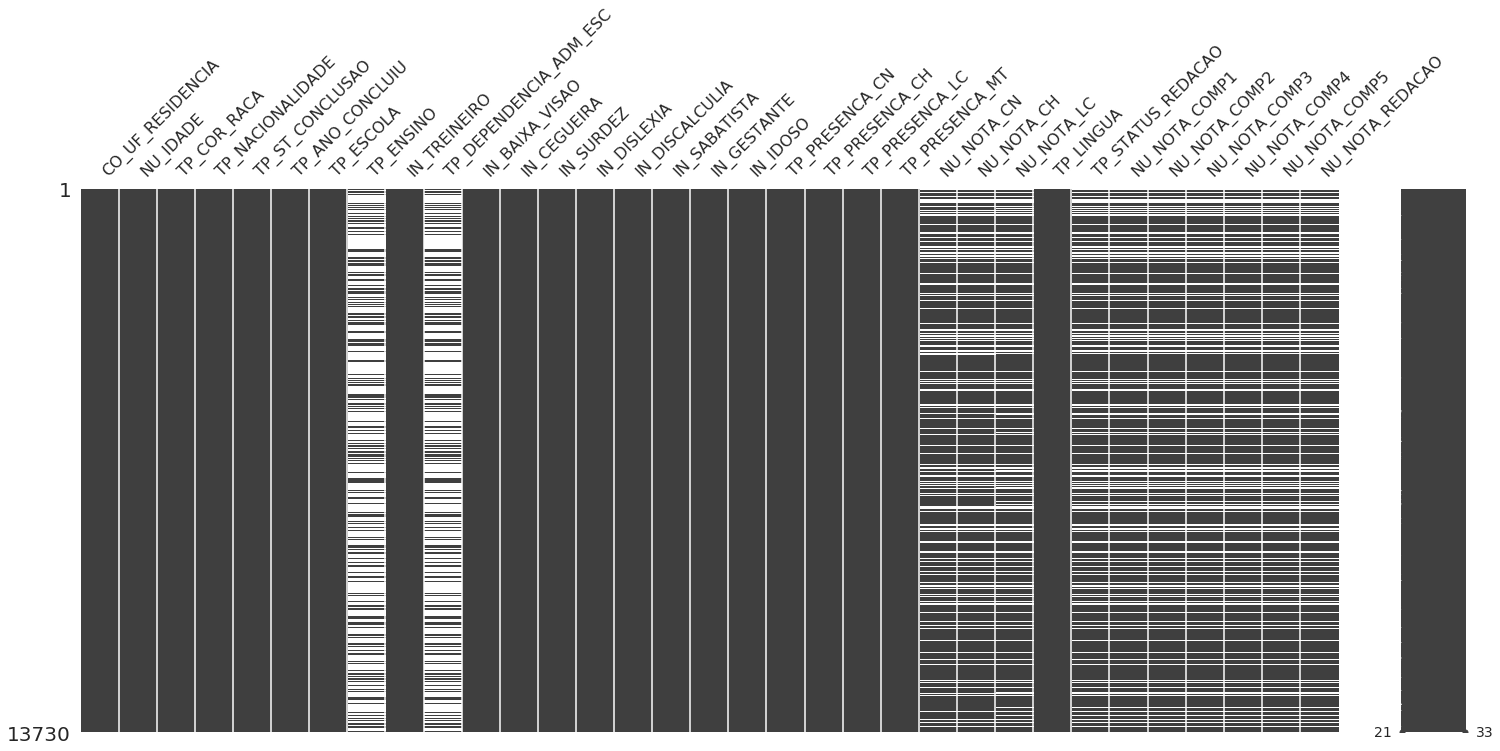

In [246]:
# Visualising missing values of numeric features
msno.matrix(train_data.select_dtypes(include=[np.number]));

* Nota-se que os valores preenchidos com NaN na coluna `NU_NOTA_CN` é exatamente o número de pessoas ausentes ou eliminadas da prova, conforme coluna `TP_PRSENCA_CN` (NU_NOTA_CN com 3389 NaNs e TP_PRESENCA_CN com 3380 valores 0 (ausente) e 9 valores 2 (eliminado)). Com isso podemos preencher os NaNs da coluna `NU_NOTA_CN` com zeros.

* Nota-se que os valores preenchidos com NaN na coluna `NU_NOTA_CH` é exatamente o número de pessoas ausentes ou eliminadas da prova, conforme coluna `TP_PRSENCA_CH` (NU_NOTA_CH com 3389 NaNs e TP_PRESENCA_CH com 3380 valores 0 (ausente) e 9 valores 2 (eliminado)). Com isso podemos preencher os NaNs da coluna `NU_NOTA_CH` com zeros.

* Nota-se que os valores preenchidos com NaN na coluna `NU_NOTA_LC` é exatamente o número de pessoas ausentes ou eliminadas da prova, conforme coluna `TP_PRSENCA_LC` (NU_NOTA_LC com 3597 NaNs e TP_PRESENCA_CN com 3592 valores 0 (ausente) e 5 valores 2 (eliminado)). Com isso podemos preencher os NaNs da coluna `NU_NOTA_LC` com zeros.

* Nota-se que os valores preenchidos com NaN na coluna `NU_NOTA_MT` é exatamente o número de pessoas ausentes ou eliminadas da prova, conforme coluna `TP_PRSENCA_LC` (NU_NOTA_LC com 3597 NaNs e TP_PRESENCA_CN com 3592 valores 0 (ausente) e 5 valores 2 (eliminado)). Ambas as provas ocorrem no mesmo dia, não tem como ser ausente em uma e presente na outra. Com isso podemos preencher os NaNs da coluna `NU_NOTA_MT` com zeros.

* Nota-se que os valores preenchidos com NaN na coluna `TP_STATUS_REDACAO`, `NU_NOTA_COMP_1`, `NU_NOTA_COMP_2`, `NU_NOTA_COMP_3`, `NU_NOTA_COMP_4`, `NU_NOTA_COMP_5` e `NU_NOTA_REDACAO` são exatamente o número de pessoas ausentes ou eliminadas da prova, conforme coluna `TP_PRSENCA_LC` (TP_STATUS_REDACAO, NU_NOTA_COMP_1, NU_NOTA_COMP_2, NU_NOTA_COMP_3, NU_NOTA_COMP_4, NU_NOTA_COMP_5 e NU_NOTA_REDACAO com 3597 NaNs e TP_PRESENCA_CN com 3592 valores 0 (ausente) e 5 valores 2 (eliminado)). Com isso podemos preencher os NaNs das colunas `TP_STATUS_REDACAO`, `NU_NOTA_COMP_1`, `NU_NOTA_COMP_2`, `NU_NOTA_COMP_3`, `NU_NOTA_COMP_4`, `NU_NOTA_COMP_5` e `NU_NOTA_REDACAO` com zeros.

* As colunas `TP_ENSINO` e `TP_DEPENDENCIA_ADM_ESC` possuem um alto número de valores faltantes (68%). Iremos excluí-las.

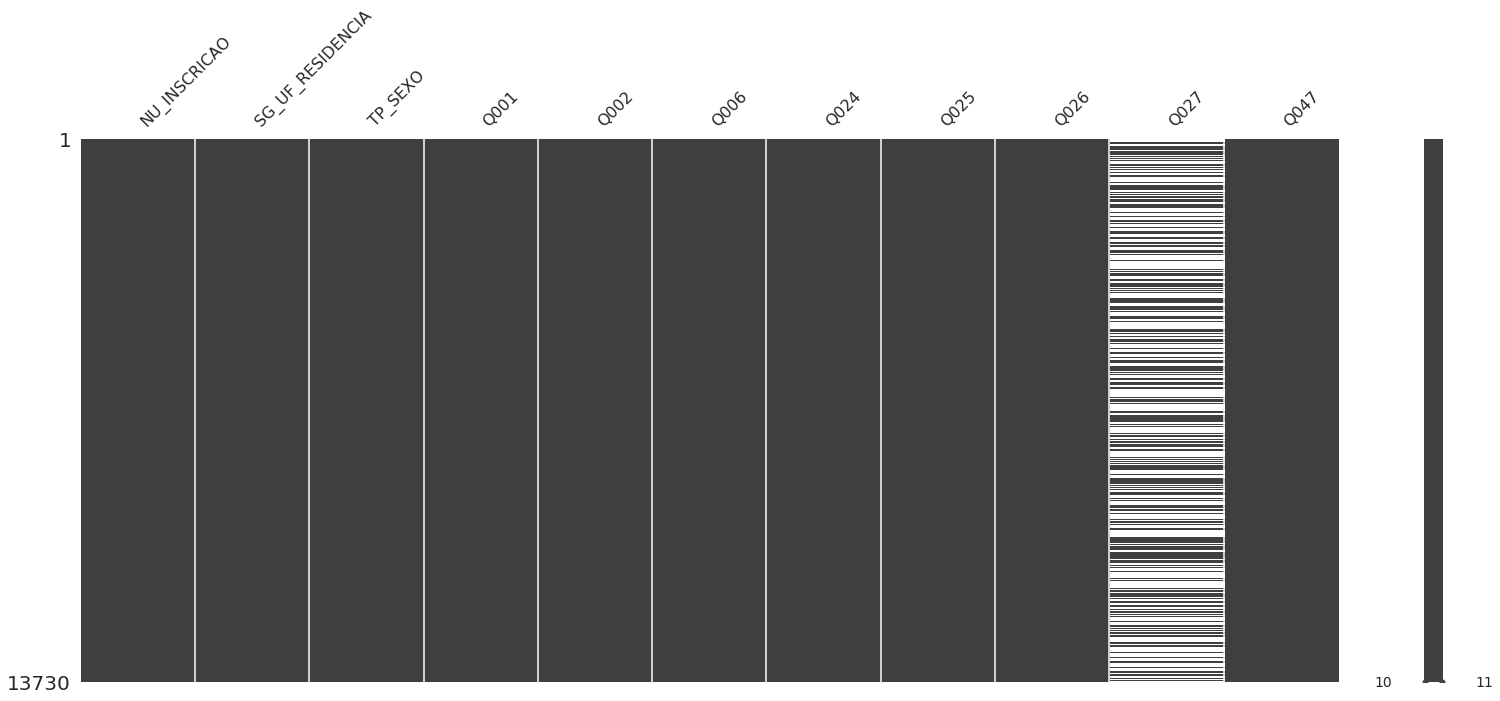

In [247]:
# Visualising missing values of object features
msno.matrix(train_data.select_dtypes(include=[np.object]));

* Nota-se que existem muitos valores preenchidos com NaN na coluna `Q027` (53.7%). Sendo assim excluiremos esta coluna.

In [248]:
exclude = ['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'Q027']

train_data.drop(columns=exclude, inplace=True)
test_data.drop(columns=exclude, inplace=True)

# Numeric features: replace with 0
temp_cols = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'TP_STATUS_REDACAO', 
             'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']

for col in temp_cols:
    train_data[col].fillna(0, inplace=True)
    test_data[col].fillna(0, inplace=True)

# Concatenate the training and test datasets into a single dataframe
data_full = pd.concat([train_data, test_data], ignore_index=True)
data_full.shape

(18300, 41)

In [249]:
# Check if missing values are imputed successfully
sum_missing_values = data_full.select_dtypes(include=[np.number]).isnull().sum()
sum_missing_values[sum_missing_values > 0].sort_values(ascending=False)

IN_TREINEIRO    4570
dtype: int64

In [250]:
# Check if missing values are imputed successfully
sum_missing_values = data_full.select_dtypes(include=[np.object]).isnull().sum()
sum_missing_values[sum_missing_values > 0].sort_values(ascending=False)

Series([], dtype: int64)

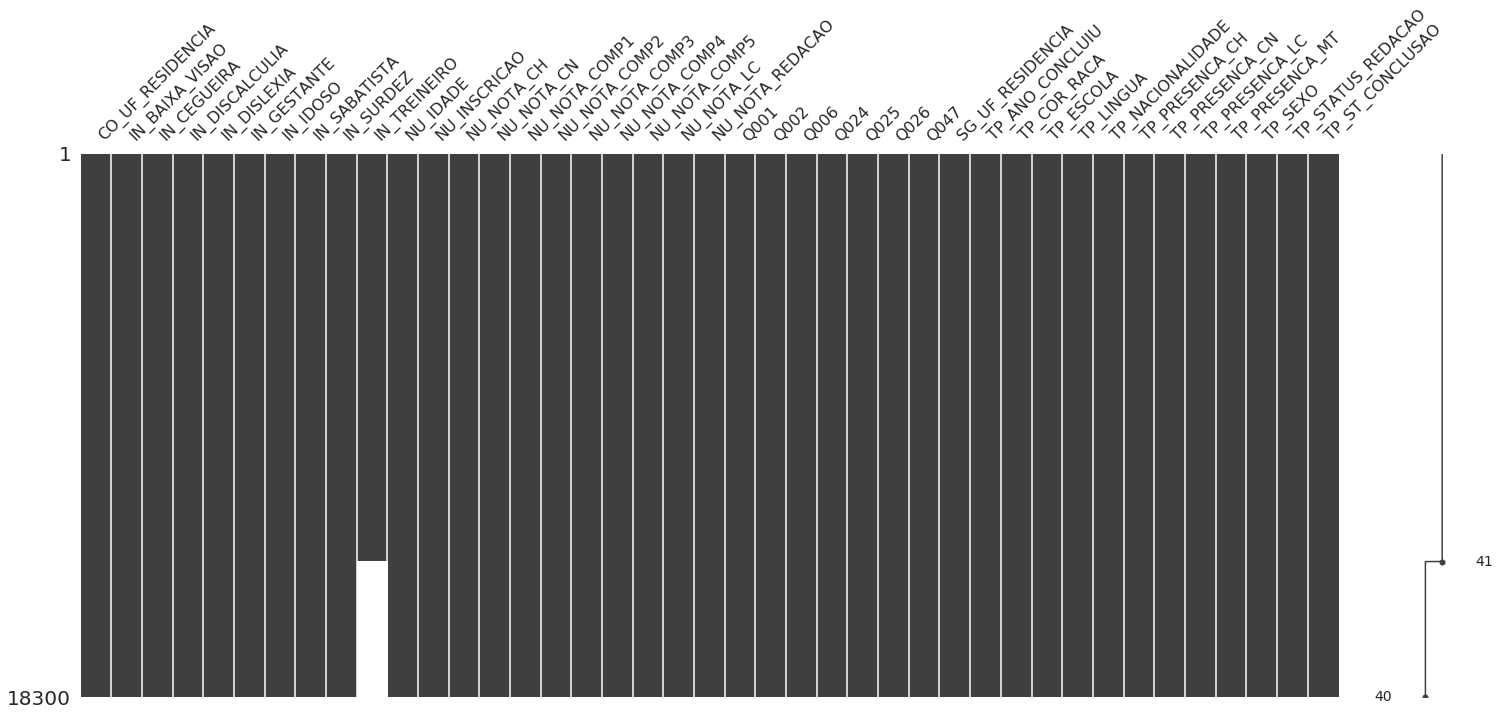

In [251]:
# Visualising missing values of all (Expected missing values just in a test set part with NU_NOTA_MT)
msno.matrix(data_full.select_dtypes(include=[np.object, np.number]));

## 05) Balanceamento da Classe Principal (SMOTE)

In [252]:
train_data["IN_TREINEIRO"].value_counts(dropna=False)

0    11947
1     1783
Name: IN_TREINEIRO, dtype: int64

In [253]:
x_train = train_data[['IN_TREINEIRO', 'TP_ST_CONCLUSAO', 'NU_IDADE', 'TP_ANO_CONCLUIU', 'TP_ESCOLA']]
x_test = test_data[['TP_ST_CONCLUSAO', 'NU_IDADE', 'TP_ANO_CONCLUIU', 'TP_ESCOLA']]

In [254]:
pca = PCA(n_components=2)
pca.fit(x_train.drop(["IN_TREINEIRO"], axis=1))

imbalanced_pca = pca.transform(x_train.drop(["IN_TREINEIRO"], axis=1))

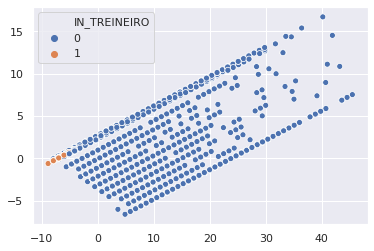

In [255]:
sns.scatterplot(imbalanced_pca[:, 0], imbalanced_pca[:, 1], hue=y_train);

In [256]:
smote = SMOTE(sampling_strategy="minority")

x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

imbalanced_pca_smote = pca.transform(X_smote)

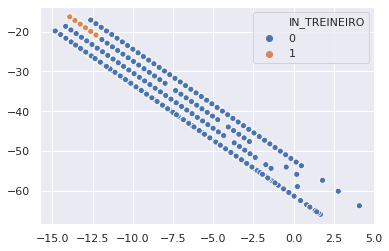

In [257]:
sns.scatterplot(x=imbalanced_pca_smote[:, 0], y=imbalanced_pca_smote[:, 1], hue=y_smote);

In [258]:
x_train_smote["IN_TREINEIRO"].value_counts(dropna=False)

1    11947
0    11947
Name: IN_TREINEIRO, dtype: int64

In [259]:
x_train_smote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23894 entries, 0 to 23893
Data columns (total 5 columns):
IN_TREINEIRO       23894 non-null int64
TP_ST_CONCLUSAO    23894 non-null int64
NU_IDADE           23894 non-null int64
TP_ANO_CONCLUIU    23894 non-null int64
TP_ESCOLA          23894 non-null int64
dtypes: int64(5)
memory usage: 933.4 KB


## 06) Seleção das Features

Vamos utilizar então apenas as variáveis `TP_ST_CONCLUSAO`, `NU_IDADE`, `TP_ANO_CONCLUIU` e `TP_ESCOLA`. Todas elas são numéricas, entretanto iremos realizar One-Hot Encoder em `TP_ST_CONCLUSAO`, `TP_ANO_CONCLUIU` e `TP_ESCOLA`.

## 07) One Hot Encoder

In [260]:
# Create a One Hot Encoder function
def one_hot_encoder(dataframe, feature):
    dummies = pd.get_dummies(dataframe[feature], prefix=feature)
    result = pd.concat([dataframe, dummies], axis=1)
    result = result.drop([feature], axis=1)
    
    return(result) 

features_to_encode = ['TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA']
                      
for feature in features_to_encode:
    x_train_smote = one_hot_encoder(x_train_smote, feature)
    x_test = one_hot_encoder(x_test, feature)

x_train_smote.head()

,IN_TREINEIRO,NU_IDADE,TP_ST_CONCLUSAO_1,TP_ST_CONCLUSAO_2,TP_ST_CONCLUSAO_3,TP_ST_CONCLUSAO_4,TP_ANO_CONCLUIU_0,TP_ANO_CONCLUIU_1,TP_ANO_CONCLUIU_2,TP_ANO_CONCLUIU_3,TP_ANO_CONCLUIU_4,TP_ANO_CONCLUIU_5,TP_ANO_CONCLUIU_6,TP_ANO_CONCLUIU_7,TP_ANO_CONCLUIU_8,TP_ANO_CONCLUIU_9,TP_ANO_CONCLUIU_10,TP_ESCOLA_1,TP_ESCOLA_2,TP_ESCOLA_3,TP_ESCOLA_4
0,0,24,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,0,17,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,21,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4,0,28,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [261]:
x_train_smote.shape, x_test.shape, y_train_smote.shape

((23894, 21), (4570, 20), (23894,))

## 08) Testando Modelos e Realizando Predição/Submissão

In [262]:
y_train = y_train_smote.copy()
x_train = x_train_smote.drop(["IN_TREINEIRO"], axis=1)

x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4570 entries, 0 to 4569
Data columns (total 20 columns):
NU_IDADE              4570 non-null int64
TP_ST_CONCLUSAO_1     4570 non-null uint8
TP_ST_CONCLUSAO_2     4570 non-null uint8
TP_ST_CONCLUSAO_3     4570 non-null uint8
TP_ST_CONCLUSAO_4     4570 non-null uint8
TP_ANO_CONCLUIU_0     4570 non-null uint8
TP_ANO_CONCLUIU_1     4570 non-null uint8
TP_ANO_CONCLUIU_2     4570 non-null uint8
TP_ANO_CONCLUIU_3     4570 non-null uint8
TP_ANO_CONCLUIU_4     4570 non-null uint8
TP_ANO_CONCLUIU_5     4570 non-null uint8
TP_ANO_CONCLUIU_6     4570 non-null uint8
TP_ANO_CONCLUIU_7     4570 non-null uint8
TP_ANO_CONCLUIU_8     4570 non-null uint8
TP_ANO_CONCLUIU_9     4570 non-null uint8
TP_ANO_CONCLUIU_10    4570 non-null uint8
TP_ESCOLA_1           4570 non-null uint8
TP_ESCOLA_2           4570 non-null uint8
TP_ESCOLA_3           4570 non-null uint8
TP_ESCOLA_4           4570 non-null uint8
dtypes: int64(1), uint8(19)
memory usage: 120.6 KB


In [263]:
# Create the model (RandomForest) and run with the train data
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(x_train, y_train)

# Generate the predictions running the model in the test data
predictions = random_forest.predict(x_test)

# Create the output file 
answer = pd.DataFrame({'NU_INSCRICAO': test_data['NU_INSCRICAO'], 'IN_TREINEIRO': predictions})

answer.to_csv("answer.csv", index=False)
answer.head()

,NU_INSCRICAO,IN_TREINEIRO
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,0
1,177f281c68fa032aedbd842a745da68490926cd2,0
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,1
3,5c356d810fa57671402502cd0933e5601a2ebf1e,0
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,0
